## Load the data and feature engineering

In [33]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.8 MB 1.5 MB/s 


In [3]:
import sklearn

sklearn.__version__

'0.24.1'

'0.24.1'

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X["random_cat"] = rng.randint(3, size=X.shape[0])
X["random_num"] = rng.randn(X.shape[0])


categorical_columns = ["pclass", "sex", "embarked", "random_cat"]
numerical_columns = ["age", "sibsp", "parch", "fare", "random_num"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

## Feature importance from mean decrease in impurity (MDI)

In [5]:
feature_names =X.columns

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

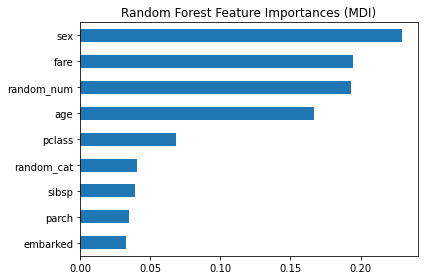

In [6]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

## Permutation Importance

### 1. Calculate on test data

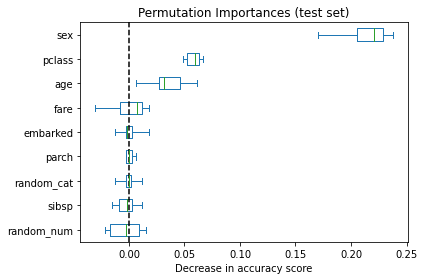

In [7]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### 2. Calculate on training data

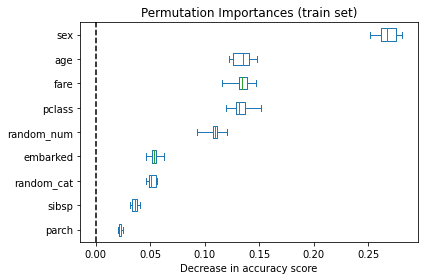

In [8]:
result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### 3. Restrcit the capacity of the trees to overfit by setting *min_samples_leaf*

In [9]:
rf.set_params(classifier__min_samples_leaf=20).fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=20, random_state=42))])

In [10]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 0.810
RF test accuracy: 0.832


### 4. Training and test dataset together

In [11]:
train_result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
test_results = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = train_result.importances_mean.argsort()

In [12]:
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

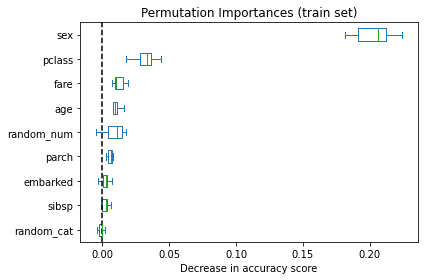

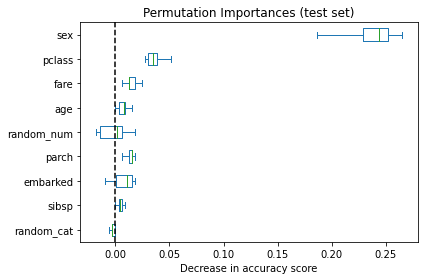

In [13]:
for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

## SHAP

In [15]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [22]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt

In [23]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

In [24]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

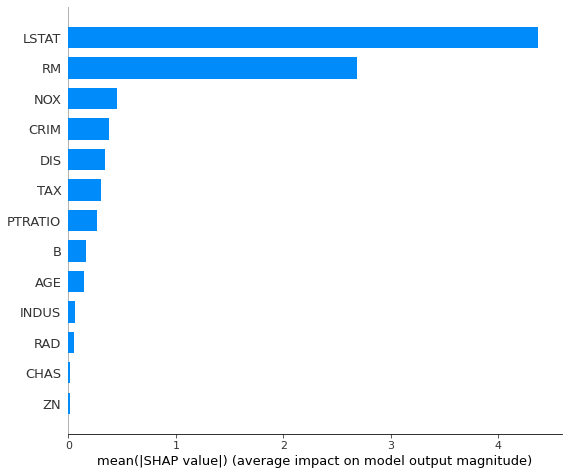

In [26]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

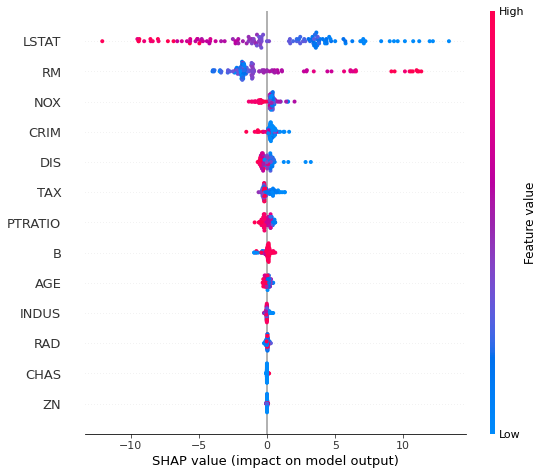

In [27]:
shap.summary_plot(shap_values, X_test)

## Reference:
1. https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
2. https://mljar.com/blog/feature-importance-in-random-forest/